# Импортируем бииблиотеки, модули и данные


## Импортирт бииблиотек

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import plotly.graph_objects as go
import plotly.express as px

import pyspark, findspark, warnings, squarify
warnings.filterwarnings('ignore') 



## Импорт модулей

In [27]:
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.functions import collect_list, concat_ws
from plotly.subplots import make_subplots
from scipy.stats import bootstrap, stats


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Импорт данных 

### Подключекние к Hive

In [3]:
# создание SparkSession с поддержкой Hive
spark = SparkSession \
    .builder \
    .appName("Spark Hive") \
    .config("spark.sql.catalogImplementation", "hive") \
    .config("spark.sql.hive.metastore.jars.path", "/usr/local/hive/hive-3.1.2/conf") \
    .enableHiveSupport() \
    .getOrCreate()


2023-06-04 05:55:03,853 WARN util.Utils: Your hostname, localhost.localdomain resolves to a loopback address: 127.0.0.1; using 192.168.0.114 instead (on interface enp0s3)
2023-06-04 05:55:03,854 WARN util.Utils: Set SPARK_LOCAL_IP if you need to bind to another address
2023-06-04 05:55:04,677 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


### Подключение к базе данных kursdb

In [4]:
spark.sql("USE kursdb")

2023-06-04 05:55:17,274 WARN conf.HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
2023-06-04 05:55:17,276 WARN conf.HiveConf: HiveConf of name hive.stats.retries.wait does not exist
2023-06-04 05:55:21,076 WARN metastore.ObjectStore: Failed to get database global_temp, returning NoSuchObjectException


DataFrame[]

### Проверка версии hive

In [5]:
spark.sql("select version();").show()

+--------------------+
|           version()|
+--------------------+
|3.1.2 de351e30a90...|
+--------------------+



### Проверка подключения к метастору Hive 


In [6]:
spark.sql("SHOW TABLES").show()

+--------+-------------------+-----------+
|database|          tableName|isTemporary|
+--------+-------------------+-----------+
|  kursdb|    courier_actions|      false|
|  kursdb|           couriers|      false|
|  kursdb|             orders|      false|
|  kursdb|           products|      false|
|  kursdb|top_10_products_315|      false|
|  kursdb|       user_actions|      false|
|  kursdb|              users|      false|
+--------+-------------------+-----------+



### Вывод существующих таблиц в hive

In [7]:
print('courier_actions'.center(60, '*'))
spark.sql('SELECT * FROM courier_actions').show(3)
print()
print('couriers'.center(60, '*'))
spark.sql('SELECT * FROM couriers').show(3)
print()
print('orders'.center(60, '*'))
spark.sql('SELECT * FROM orders').show(3)
print()
print('products'.center(60, '*'))
spark.sql('SELECT * FROM products').show(3)
print()
print('users'.center(60, '*'))
spark.sql('SELECT * FROM users').show(3)
print()
print('user_actions'.center(60, '*'))
spark.sql('SELECT * FROM user_actions').show(3)

**********************courier_actions***********************


+----------+--------+-------------+-------------------+
|courier_id|order_id|       action|       deliver_time|
+----------+--------+-------------+-------------------+
|      null|    null|       action|               null|
|        12|       1| accept_order|2022-08-24 01:52:00|
|        12|       1|deliver_order|2022-08-24 02:15:00|
+----------+--------+-------------+-------------------+
only showing top 3 rows


**************************couriers**************************
+----------+----------+------+
|courier_id|birth_date|   sex|
+----------+----------+------+
|      null|      null|   sex|
|         1|1981-06-11|female|
|         2|1991-06-27|  male|
+----------+----------+------+
only showing top 3 rows


***************************orders***************************
+--------+-------------------+-----------+
|order_id|      creation_time|product_ids|
+--------+-------------------+-----------+
|    null|               null|     [null]|
|       1|2022-08-24 01:52:00|     [null]|
| 

# Часть анализа

## 	Динамика прироста числа новых пользователей и курьеров

In [9]:
Dynamics_growth_users = """
    WITH t1 AS (
      SELECT user_id,
             min(to_date(deliver_time)) AS user_first_date
      FROM user_actions
      WHERE action != 'cancel_order'
      GROUP BY user_id
    ), t2 AS (
      SELECT courier_id,
             min(to_date(deliver_time)) AS courier_first_date
      FROM courier_actions
      GROUP BY courier_id
    ), t3 AS (
      SELECT t1.user_first_date AS order_date,
             count(DISTINCT t1.user_id) AS new_users,
             count(DISTINCT t2.courier_id) AS new_couriers
      FROM t1 JOIN t2
      ON t1.user_first_date = t2.courier_first_date
      GROUP BY t1.user_first_date
    ), t4 AS (
      SELECT order_date,
             new_users,
             new_couriers,
             sum(new_users) OVER (ORDER BY order_date) AS total_users,
             sum(new_couriers) OVER (ORDER BY order_date) AS total_couriers
      FROM t3
      ORDER BY order_date
    ), t5 AS (
      SELECT order_date,
             new_users,
             new_couriers,
             total_users,
             total_couriers,
             ((new_users - lag(new_users, 1) OVER (ORDER BY order_date)) / lag(new_users, 1) OVER (ORDER BY order_date)) * 100 AS new_users_change,
             ((new_couriers - lag(new_couriers, 1) OVER (ORDER BY order_date)) / lag(new_couriers, 1) OVER (ORDER BY order_date)) * 100 AS new_couriers_change,
             ((total_users - lag(total_users, 1) OVER (ORDER BY order_date)) / lag(total_users, 1) OVER (ORDER BY order_date)) * 100 AS total_users_growth,
             ((total_couriers - lag(total_couriers, 1) OVER (ORDER BY order_date)) / lag(total_couriers, 1) OVER (ORDER BY order_date)) * 100 AS total_couriers_growth
      FROM t4
    )
    SELECT order_date,
           new_users,
           new_couriers,
           total_users,
           total_couriers,
           round(new_users_change, 2) AS new_users_change,
           round(new_couriers_change, 2) AS new_couriers_change,
           round(total_users_growth, 2) AS total_users_growth,
           round(total_couriers_growth, 2) AS total_couriers_growth
    FROM t5;
"""

Dynamics_growth_df = spark.sql(Dynamics_growth_users).toPandas()

2023-06-04 05:55:30,997 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
2023-06-04 05:55:31,003 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


**На счет ошибки про партиции**

В оконном анализе данные обычно разделяются на группы, называемые партициями, и для каждой партиции выполняются вычисления независимо. Это позволяет распараллеливать вычисления и повышает производительность. Однако, если не указано явное разделение на партиции, то все данные считаются принадлежащими одной партиции.

In [10]:
Dynamics_growth_df['order_date'] =  pd.to_datetime(Dynamics_growth_df['order_date'])
# Dynamics_growth_df

In [11]:
# Составление макета графика
fig = make_subplots(
    rows=3, cols=1,
    subplot_titles=[
        'Динамика новых пользователей',
        'Динамика прироста числа новых пользователей и курьеров',
        'Динамика прироста общего числа пользователей и курьеров'
        ]
    )

# Построение графиков
line_fig = px.line(
        data_frame=Dynamics_growth_df,
        x='order_date',
        y=['new_users', 'new_couriers'],
        title='Динамика новых пользователей',
        color_discrete_sequence=['#EB1D36', '#635985']
    )


bar_fig = px.bar(
        data_frame=Dynamics_growth_df,
        x='order_date',
        y=['new_users_change', 'new_couriers_change'],
        title='Динамика прироста числа новых пользователей и курьеров',
        color_discrete_sequence=['#7E1717', '#E57C23']
    )

bar_fig2 = px.bar(
        data_frame=Dynamics_growth_df,
        x='order_date',
        y=['total_users_growth', 'total_couriers_growth'],
        title='Динамика прироста общего числа пользователей и курьеров',
        color_discrete_sequence=['#497174', '#372948']
    )


# Добавсление графиков на полотно
for trace in line_fig.data:
    fig.add_trace(trace, row=1, col=1)
    
for trace in bar_fig.data:
    fig.add_trace(trace, row=2, col=1)

for trace in bar_fig2.data:
    fig.add_trace(trace, row=3, col=1)
    
for ann in fig.layout.annotations:
    ann.font.size = 22

# Настройки полотна
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=False,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=16,
            color='rgb(82, 82, 82)',
        ),
    ),
    yaxis=dict(
        showgrid=False,
        zeroline=False,
        showline=False,
        showticklabels=True,
    ),
    autosize=False,
    margin=dict(
        autoexpand=False,
        l=100,
        r=200,
        t=110,
    ),
    showlegend=True,
    width=980, 
    height=950,
    plot_bgcolor='#F9F9F9'
)

fig.show();


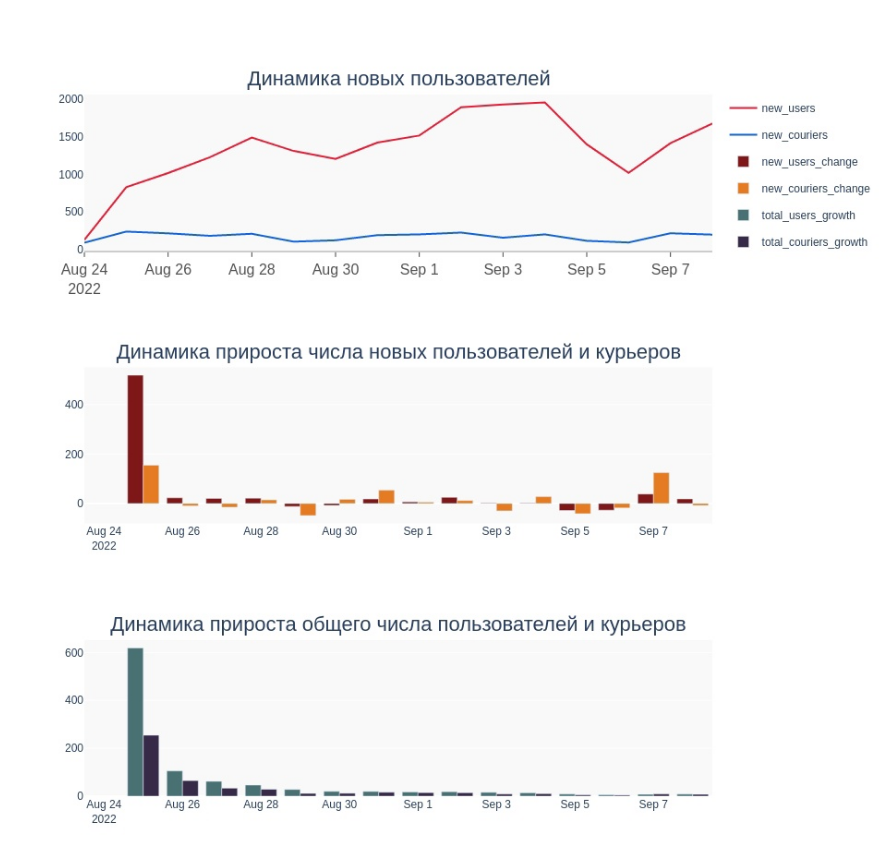


   * На первом графике можем видеть, что рост курьеров достаточно стабилен в отличие от роста новых пользователей, так же можно увидеть небольшую корреляцию между числом новых курьеров и числа новых пользователей. Это может говорит нам о том, что рост курьеров поспевает за ростом пользователей. 
   
   * Анализируя динамику показателей из первого графика, можно заметить, что сравнивать абсолютные значения не очень удобно. Поэтому представим динамику новых пользователей в относительных величинах.
    
* Теперь, когда мы может наблюдать график с относительными величинами, мы можем увидеть, что показатель числа новых курьеров не такой уж и стабильный как могло показаться на первый взгляд. 

* Иногда смотря на динамику новых пользователей не всегда можно сделать какие-то четкие выводы, поэтому полезно будет узнать метрику DAU. Которая показывает не только новых пользователей, а и в целом активность пользователей в нашем сервисе. 

## Расчет метрики DAU

In [12]:
DAU_query = """
    SELECT 
      to_date(deliver_time) AS day_active,
      COUNT(DISTINCT user_id) AS DAU
    FROM 
      user_actions
    WHERE 
      action = 'create_order'
    GROUP BY 
      to_date(deliver_time)
    ORDER BY
      to_date(deliver_time);
"""

DAU_df = spark.sql(DAU_query).toPandas()
DAU_df = DAU_df.iloc[1:, :]

In [13]:
DAU_df

day_active   DAU
1   2022-08-25   848
2   2022-08-26  1183
3   2022-08-27  1604
4   2022-08-28  2145
5   2022-08-29  2287
6   2022-08-30  2340
7   2022-08-31  2535
8   2022-09-01  2815
9   2022-09-02  3547
10  2022-09-03  3907
11  2022-09-04  4236
12  2022-09-05  3479
13  2022-09-06  2799
14  2022-09-07  3639
15  2022-09-08  4028

In [14]:
# Вычисляем изменение DAU относительно предыдущего дня
delta_dau = [DAU_df['DAU'].iloc[i] - DAU_df['DAU'].iloc[i-1] if i > 0 else DAU_df['DAU'].iloc[i] for i in range(len(DAU_df))]


# Добавляем трейс Waterfall в фигуру
fig2 = go.Figure(
    go.Waterfall(
        x=DAU_df['day_active'],
        y=delta_dau,
        base=0,
        name='Waterfall Chart - Ежедневное количество активных пользователей (DAU)', 
        textposition='inside',
        text=delta_dau,
        measure=['absolute'] + ['relative'] * (len(DAU_df['day_active']) - 1),
        decreasing = {"marker":{"color":"Maroon", "line":{"color":"red", "width":2}}},
        increasing = {"marker":{"color":"Teal"}},
        totals = {"marker":{"color":"deep sky blue", "line":{"color":"blue", "width":3}}}
    )
)

    
# Обновляем макет фигуры
fig2.update_layout(
    title='Waterfall Chart - Ежедневное количество активных пользователей (DAU)',
    xaxis_title='Дата',
    yaxis_title='Изменение DAU',
    showlegend=False,
    plot_bgcolor='#F9F9F9',
    xaxis=dict(
        showline=True,
        showgrid=False,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=16,
            color='rgb(82, 82, 82)',
        ),
    ),
    yaxis=dict(
        showgrid=False,
        zeroline=False,
        showline=False,
        showticklabels=True,
    ),
    width=1000, 
    height=550,
    waterfallgap = 0.3
)



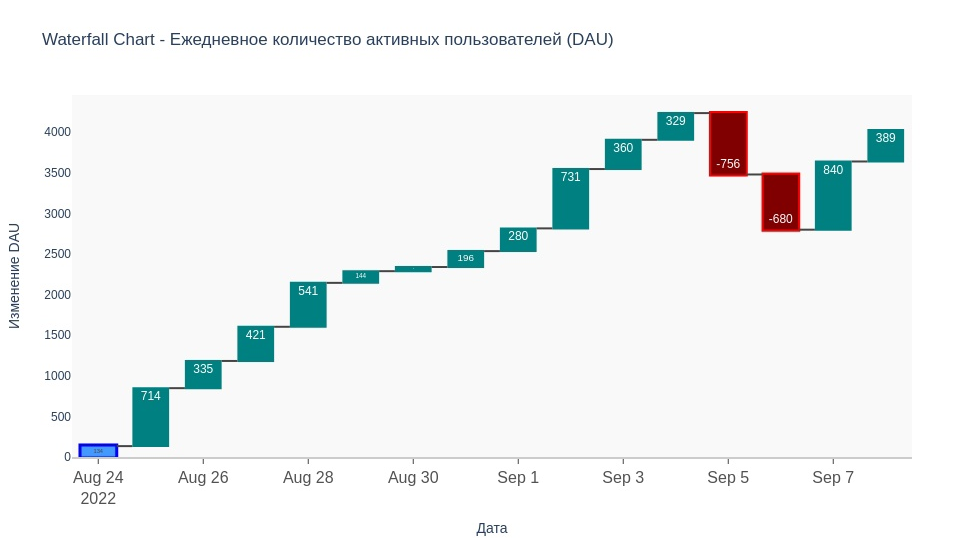

**Исходя из этих данных, можно сделать следующие выводы:**

* DAU растет с течением времени, что свидетельствует о росте популярности вашего сервиса доставки продуктов питания.
* DAU имеет некоторые колебания в зависимости от дня недели. Например, вы можете заметить, что в выходные дни (29-31 августа и 5-6 сентября) ваш DAU ниже, чем в будние дни. Это может означать, что у пользователи в связи с работой или делами не могут тратить лишнее время в будние дни и предпочитают сделать заказа, нежели сходить в магазин, тем самым съэкономив время.
* DAU имеет один явный спад 6 сентября, который может быть связан с каким-то особым событием или фактором, который повлиял на спрос на ваш сервис. Например, это мог быть праздничный или рабочий день, когда многие люди не были дома или предпочитали готовить самостоятельно.

## 	Расчет метрик APPRU, APPU, AOV


In [15]:
APPU_query = """
    SELECT
      t1.deliver_date, 
      ROUND(CAST(revenue AS double) / users, 2) AS arpu,
      ROUND(CAST(revenue AS double) / paying_users, 2) AS arppu,
      ROUND(CAST(revenue AS double) / orders, 2) AS aov
    FROM (
      SELECT
        t4.deliver_date,
        COUNT(DISTINCT t4.order_id) AS orders,
        SUM(t4.price) AS revenue
      FROM (
        SELECT
          o.order_id,
          CAST(o.creation_time AS DATE) AS deliver_date,
          p.price
        FROM
          orders o
          JOIN (
            SELECT
              order_id,
              CAST(creation_time AS DATE) AS creation_date,
              product_id
            FROM
              orders LATERAL VIEW explode(product_ids) exploded AS product_id
          ) o_exploded ON o.order_id = o_exploded.order_id
          JOIN products p ON o_exploded.product_id = p.product_id
        WHERE
          o.order_id NOT IN (
            SELECT
              order_id
            FROM
              user_actions
            WHERE
              action = 'cancel_order'
          )
      ) t4
      GROUP BY
        t4.deliver_date
    ) t1
    LEFT JOIN (
      SELECT
        CAST(ua.deliver_time AS DATE) AS deliver_date,
        COUNT(DISTINCT ua.user_id) AS users
      FROM
        user_actions ua  
      GROUP BY
        CAST(ua.deliver_time AS DATE)
    ) t2 ON t1.deliver_date = t2.deliver_date 
    LEFT JOIN (
      SELECT
        CAST(ua_filtered.deliver_time AS DATE) AS deliver_date,
        COUNT(DISTINCT ua_filtered.user_id) AS paying_users  
      FROM (
        SELECT
          ua.deliver_time,
          ua.user_id,
          ua.order_id  
        FROM
          user_actions ua 
          LEFT JOIN (
            SELECT
              order_id
            FROM
              user_actions 
            WHERE
              action = 'cancel_order'
          ) ua_cancel ON ua.order_id = ua_cancel.order_id 
        WHERE
          ua_cancel.order_id IS NULL 
      ) ua_filtered 
      GROUP BY
        CAST(ua_filtered.deliver_time AS DATE)
    ) t3 ON t1.deliver_date = t3.deliver_date 
    ORDER BY
      t1.deliver_date; 
"""

metrix = spark.sql(APPU_query).toPandas()

In [24]:
metrix.head()

date    arpu   arppu     aov
0  2022-08-24  372.57  393.10  361.77
1  2022-08-25  508.09  525.44  406.86
2  2022-08-26  452.04  470.33  369.57
3  2022-08-27  509.38  527.81  381.62
4  2022-08-28  528.38  544.10  378.04

## 	Динамика прибыли

In [18]:
Profit_dynamics_query = """
    WITH order_items AS (
      SELECT
        orders.order_id,
        product_id,
        creation_time
      FROM
        orders LATERAL VIEW explode(product_ids) product_id_table AS product_id
      WHERE
        orders.order_id NOT IN (
          SELECT
            order_id
          from
            courier_actions
          WHERE
            action = 'cancel_order'
        )
    ),
    daily_revenue AS (
      SELECT
        from_unixtime(
          unix_timestamp(orders.creation_time),
          'yyyy-MM-dd'
        ) AS order_date,
        SUM(products.price) AS revenue
      FROM
        order_items
        JOIN orders ON order_items.order_id = orders.order_id
        CROSS JOIN products
      WHERE
        order_items.product_id = products.product_id
      GROUP BY
        from_unixtime(
          unix_timestamp(orders.creation_time),
          'yyyy-MM-dd'
        )
    )
    SELECT
      order_date,
      revenue,
      SUM(revenue) OVER (
        ORDER BY
          order_date
      ) AS total_revenue,
      ROUND(
        (
          revenue - LAG(revenue) OVER (
            ORDER BY
              order_date
          )
        ) / LAG(revenue) OVER (
          ORDER BY
            order_date
        ) * 100,
        2
      ) AS revenue_change
    FROM
      daily_revenue
    ORDER BY
      order_date;
"""
revenue = spark.sql(Profit_dynamics_query).toPandas()


In [20]:
revenue.head()

order_date    revenue  total_revenue  revenue_change
0  2022-08-24    53432.0        53432.0            0.00
1  2022-08-25   449871.0       503303.0          741.95
2  2022-08-26   563787.0      1067090.0           25.32
3  2022-08-27   859549.0      1926639.0           52.46
4  2022-08-28  1191363.0      3118002.0           38.60

In [21]:
revenue['order_date'] = pd.to_datetime(revenue['order_date'])

revenue['day_of_week'] = revenue['order_date'].dt.day_name()

revenue_by_day = revenue.groupby('day_of_week')['revenue', 'total_revenue', 'revenue_change'].sum()

revenue_by_day.reset_index(inplace=True)

revenue_by_day['day_type'] = revenue_by_day['day_of_week'].apply(lambda x: 'Weekday' if x in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'] else 'Weekend')

revenue_by_day.sort_values(by='day_type')

day_of_week    revenue  total_revenue  revenue_change day_type
0      Friday  2570520.0     11764874.0           60.39  Weekday
1      Monday  3229893.0     21776916.0           -8.68  Weekday
4    Thursday  4131899.0     32016082.0          763.53  Weekday
5     Tuesday  2749457.0     24526373.0          -25.47  Weekday
6   Wednesday  3357810.0     27884183.0           39.73  Weekday
2    Saturday  3184969.0     14949843.0           68.34  Weekend
3      Sunday  3597180.0     18547023.0           42.06  Weekend

In [22]:
fig = px.sunburst(
    data_frame=revenue_by_day,
    path=['day_type', 'day_of_week'],
    values='revenue',
    color='revenue',
    color_continuous_scale='pubu',
    title='Выручка по дням недели',
    color_continuous_midpoint=np.average(revenue_by_day['revenue'])
)

fig.update_layout(
    width=800,
    height=600
)



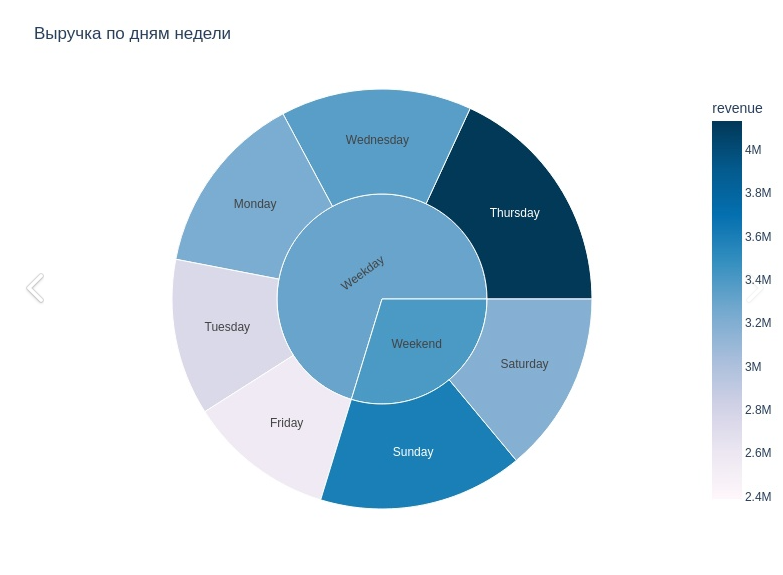

- На основе диаграммы можно сделать вывод, что некоторые дни недели выделяются высокой выручкой, в то время как другие дни имеют минимальную выручку. Например, четверг является одним из наиболее прибыльных дней, в то время как пятница и среда имеют наименьшую выручку. Выходные дни характеризуются равномерным распределением выручки.

- Из предыдущего анализа графиков мы выяснили, что клиенты более активны в будние дни, вероятно, из-за ограниченного времени для походов в магазин. На основе этой информации выдвигается гипотеза, что выручка в будние дни выше, чем в выходные. Однако, из-за ограниченного количества данных (сервис работает всего 16 дней) и отсутствия нормального распределения, проведение статистических тестов затруднено. Вместо этого, мы можем использовать технику, известную как «Bootstrap»


### Проверка гипотезы о доходах в разные дни неели
* H0: revenue in weekday == revenue in weekend
*  H1: revenue in weekday > revenue in weekend

In [28]:
revenue_weekday = revenue_by_day[revenue_by_day['day_type'] == 'Weekday']['revenue']
revenue_weekend = revenue_by_day[revenue_by_day['day_type'] == 'Weekend']['revenue']
 

def bootstrap_mean(data, num_iterations):
    n = len(data)
    bootstrap_means = []
    
    for _ in range(num_iterations):
        bootstrap_sample = np.random.choice(data, size=n, replace=True)
        bootstrap_mean = np.mean(bootstrap_sample)
        bootstrap_means.append(bootstrap_mean)
    
    return bootstrap_means


bootstrap_weekday = bootstrap_mean(revenue_weekday, num_iterations=1000)
bootstrap_weekend = bootstrap_mean(revenue_weekend, num_iterations=1000)


t_statistic, p_value = stats.ttest_ind(bootstrap_weekday, bootstrap_weekend, alternative='greater')

alpha = 0.05

if p_value <= alpha:
    print("Отвергаем нулевую гипотезу. Есть доказательства в пользу H1: выручка в будние дни больше выручки в выходные дни.")
else:
    print("Не удалось отвергнуть нулевую гипотезу. Недостаточно доказательств в пользу H1.")

print("T-статистика:", t_statistic)
print("P-значение:", p_value)  

Не удалось отвергнуть нулевую гипотезу. Недостаточно доказательств в пользу H1.
T-статистика: -20.69930093067912
P-значение: 1.0


In [29]:
fig = go.Figure(
    go.Scatter(
        x=revenue['order_date'],
        y=revenue['revenue'],
        mode='lines+markers+text',
        marker=dict(
            size=8,
            color='#005792',
            line=dict(width=2, color='#005792'),
            symbol='circle',
            opacity=0.7
        ),
        text=revenue['revenue_change'],
        textposition='top center',
        name='Выручка',
        textfont=dict(color='maroon') 
    )
)


fig.update_layout(
    title='Выручка за день',
    xaxis=dict(
        title='Дата',
        tickformat='%Y-%m-%d',
        showgrid=True,
        gridcolor='lightgray',
        gridwidth=0.1, 
        linewidth=0.5
    ),
    yaxis=dict(
        title='Выручка',
        showgrid=True,
        gridcolor='lightgray',
        linewidth=0.5
    ),
    hovermode='x',
    legend=dict(
        x=0.02,
        y=0.98,
        bgcolor='rgba(255, 255, 255, 0.8)',
        bordercolor='gray',
        borderwidth=0.5,
    ),
    showlegend=True,
    width=1050, 
    height=550,
    plot_bgcolor='#F9F9F9',
    
)



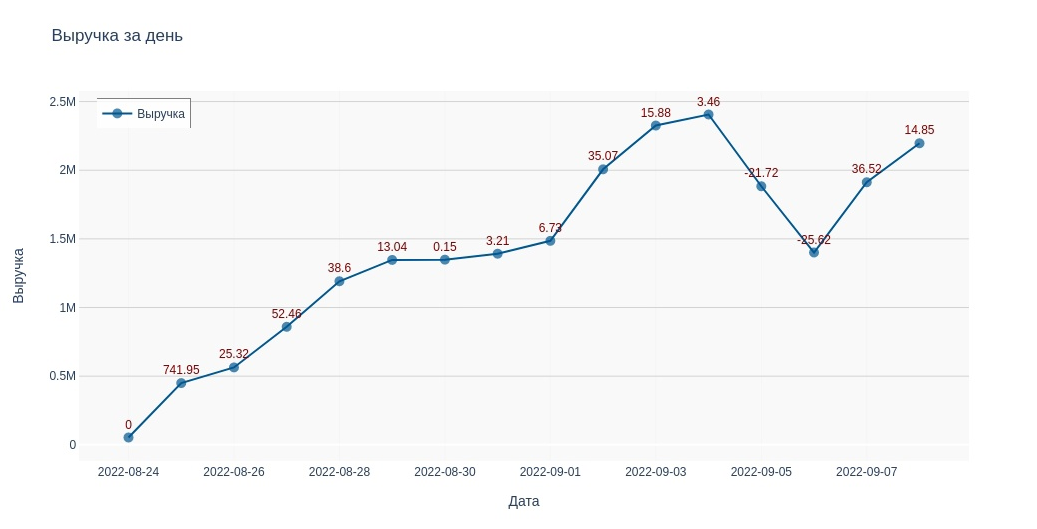

- На графике мы можем наблюдать положительную динамику за исключением тех дней, где ранее рассчитанная метрика DAU была отрицательной.

- Анализ распределения выручки по дням недели дает ценную информацию о финансовой динамике сервиса. Мы можем определить наиболее прибыльные дни и принять решения по планированию ресурсов и оптимизации маркетинга для улучшения эффективности бизнеса


## 	Средний интервал в часах между заказами пользователей

In [98]:
avg_interval_query = """
    SELECT 
        t.user_id,
        round(cast(avg(cast(t.time_diff as bigint)) as bigint) / 3600) as hours_between_orders
    FROM (
      SELECT 
          ua.user_id,
          ua.order_id,
          ua.deliver_time,
          unix_timestamp(ua.deliver_time) - lag(unix_timestamp(ua.deliver_time), 1) OVER (PARTITION BY ua.user_id ORDER BY ua.deliver_time) as time_diff
      FROM 
          user_actions ua
      WHERE ua.order_id NOT IN (
        SELECT 
            order_id
        FROM 
            user_actions
        WHERE action = 'cancel_order'
      )
    ) t
    WHERE 
        t.time_diff IS NOT NULL
    GROUP BY
        t.user_id
    ORDER BY
        t.user_id

"""

avg_interval_df = spark.sql(avg_interval_query).toPandas()
avg_interval_df = avg_interval_df[
        avg_interval_df['hours_between_orders'] > 2
]

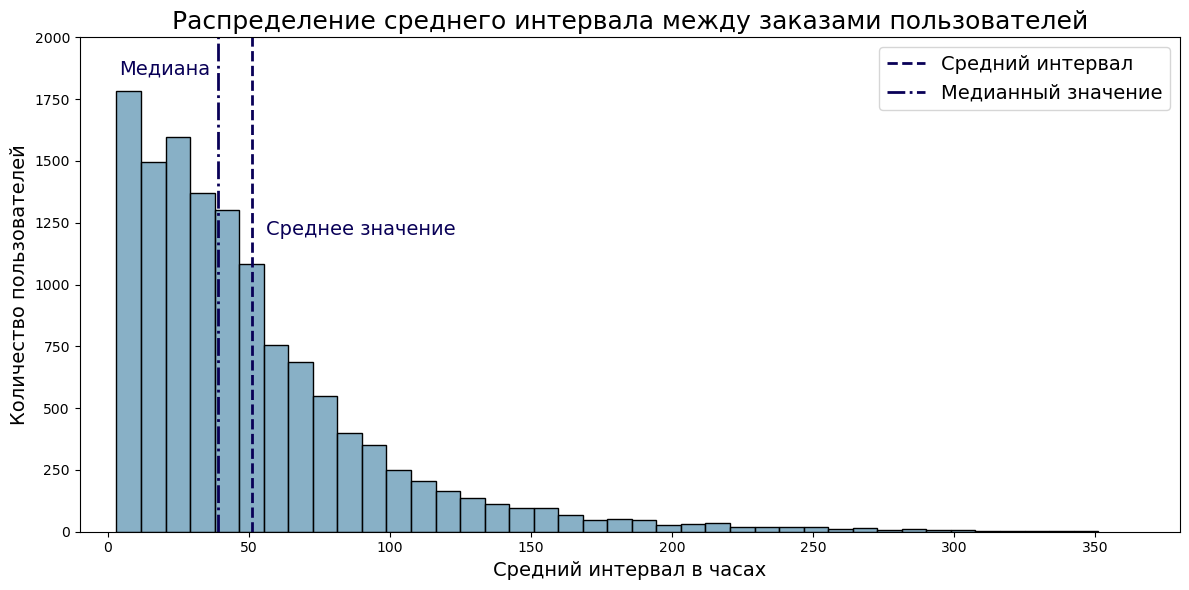

In [105]:
plt.figure(figsize=(12, 6))
sns.histplot(
    data=avg_interval_df,
    x='hours_between_orders',
    legend=True,
    shrink=1,
    bins=40,
    color='#6096B4'
)

plt.axvline(
    x=avg_interval_df['hours_between_orders'].mean(),
    color='#090057',
    linestyle='--',
    label='Средний интервал',
    linewidth=2
)
plt.axvline(
    x=avg_interval_df['hours_between_orders'].median(),
    color='#090057',
    linestyle='-.',
    label='Медианный значение',
    linewidth=2
)
plt.text(
    x=avg_interval_df['hours_between_orders'].mean() + 5,
    y=1200, s='Среднее значение',
    color='#090057',
    fontsize=14
)
plt.text(
    x=avg_interval_df['hours_between_orders'].median() -35,
    y=1850, s='Медиана',
    color='#090057',
    fontsize=14
)
plt.legend(prop={'size': 14})

plt.title('Распределение среднего интервала между заказами пользователей', fontsize=18)
plt.xlabel('Средний интервал в часах', fontsize=14)
plt.ylabel('Количество пользователей', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.ylim(0, 2000)
plt.xlim(-10, 380)

plt.grid(visible=False)
plt.show();

    Анализируя график распределения среднего интервала между заказами пользователей, можно сделать, что в среднем пользователи сервиса делают свой заказ через 50 часов, что составляет почти двое суток. Однако, из-за сильного перекоса влево, среднее значение может быть не очень репрезентативным. В так ситуации более точным показателем является медиана, которая находится в районе 42 часов

## Время между заказами пользователей


In [32]:
Time_between_orders_query = """
WITH t1 AS (
  SELECT user_id,
         order_id,
         deliver_time,
         row_number() OVER (PARTITION BY user_id ORDER BY deliver_time) AS order_number,
         lag(deliver_time, 1) OVER (PARTITION BY user_id ORDER BY deliver_time) AS time_lag
  FROM user_actions
  WHERE order_id NOT IN (
    SELECT order_id
    FROM user_actions
    WHERE action = 'cancel_order'
  )
)
SELECT user_id,
       order_id,
       deliver_time,
       order_number,
       time_lag,
       unix_timestamp(deliver_time) - unix_timestamp(time_lag) AS time_diff
FROM t1
ORDER BY user_id, order_number
"""

Time_between_orders_df = spark.sql(Time_between_orders_query).toPandas()


In [33]:
Time_between_orders_df.head(10)

user_id  order_id        deliver_time  order_number            time_lag  \
0        1         1 2022-08-24 01:52:00             1                 NaT   
1        1      4683 2022-08-27 20:56:00             2 2022-08-24 01:52:00   
2        1     22901 2022-09-02 00:58:00             3 2022-08-27 20:56:00   
3        1     23149 2022-09-02 02:36:00             4 2022-09-02 00:58:00   
4        2         2 2022-08-24 06:37:00             1                 NaT   
5        2      7114 2022-08-28 18:11:00             2 2022-08-24 06:37:00   
6        3         3 2022-08-24 07:35:00             1                 NaT   
7        3      6735 2022-08-28 15:53:00             2 2022-08-24 07:35:00   
8        3     18137 2022-08-31 20:26:00             3 2022-08-28 15:53:00   
9        3     19793 2022-09-01 08:53:00             4 2022-08-31 20:26:00   

   time_diff  
0        NaN  
1   327840.0  
2   446520.0  
3     5880.0  
4        NaN  
5   387240.0  
6        NaN  
7   375480.0  
8   275580.0  
9    44820.0

## 	Дескриптивная статистика пользователей

In [35]:
Descriptive_statistics_query = """
    WITH t1 AS (
        SELECT
          ua.user_id,
          o.order_id,
          o.product_ids
        FROM 
          user_actions ua
        LEFT JOIN orders o
            ON ua.order_id = o.order_id
        WHERE ua.order_id NOT IN (
            SELECT 
              order_id
            FROM 
              user_actions
            WHERE action = 'cancel_order'
        )
    ), t2 AS (
        SELECT 
          t1.user_id,
          t1.order_id,
          count(p.product_id) AS count_p,
          sum(p.price) AS sum_p
        FROM 
          t1
        JOIN products p
            ON array_contains(t1.product_ids, p.product_id)
        GROUP BY 
          t1.user_id, t1.order_id
    )
    SELECT 
      user_id,
      count(order_id) AS orders_count,
      round(avg(count_p), 2) AS avg_order_size,
      sum(sum_p) AS sum_order_value,
      round(avg(sum_p), 2) AS avg_order_value,
      min(sum_p) AS min_order_value,
      max(sum_p) AS max_order_value
    FROM 
      t2
    GROUP BY 
      user_id
    ORDER BY 
      user_id;

"""

Descriptive_statistics_df = spark.sql(Descriptive_statistics_query).toPandas()

In [36]:
Descriptive_statistics_df.head()

user_id  orders_count  avg_order_size  sum_order_value  avg_order_value  \
0        1             4            2.75           1206.0            301.5   
1        2             2            3.50            540.0            270.0   
2        3             4            4.00           2154.0            538.5   
3        4             2            3.00            329.0            164.5   
4        5             1            1.00             51.0             51.0   

   min_order_value  max_order_value  
0            170.0            640.0  
1            146.0            394.0  
2            336.0            772.0  
3            156.0            173.0  
4             51.0             51.0

In [37]:
def calculate_ltv(row):
    sum_order_value = row['sum_order_value']
    orders_count = row['orders_count']
    
    avg_order_value = sum_order_value / orders_count
    orders_per_month = orders_count / 16
    
    ltv = avg_order_value * orders_per_month * 30
    
    return ltv

Descriptive_statistics_df['LTV'] = Descriptive_statistics_df.apply(calculate_ltv, axis=1)

Descriptive_statistics_df.head()


user_id  orders_count  avg_order_size  sum_order_value  avg_order_value  \
0        1             4            2.75           1206.0            301.5   
1        2             2            3.50            540.0            270.0   
2        3             4            4.00           2154.0            538.5   
3        4             2            3.00            329.0            164.5   
4        5             1            1.00             51.0             51.0   

   min_order_value  max_order_value     LTV  
0            170.0            640.0  2412.0  
1            146.0            394.0  1080.0  
2            336.0            772.0  4308.0  
3            156.0            173.0   658.0  
4             51.0             51.0   102.0

**Расчитанный LVT  поможет вдальнейшем прогнорироват отток клиентов и 
с расчитанным LTV  можно делать разные вещи, в зависимости от целей и задач. Вот некоторые из них:**

 ---
* 	Сравнивать LTV с CAC (стоимостью привлечения клиента) и оценивать рентабельность и эффективность маркетинговых кампаний и каналов привлечения. В идеале, LTV должен быть выше CAC, чтобы не работать в убыток.
* 	Сегментировать клиентов по их LTV и определять самых ценных и лояльных клиентов для вашего бизнеса. Вы можете предлагать им специальные условия, бонусы, скидки или персонализированные предложения, чтобы повысить их удовлетворенность и удержание.
* 	Анализировать факторы, которые влияют на LTV клиентов, такие как средний чек, количество покупок, продолжительность жизни клиента, маржинальность товаров и т.д. Вы можете проводить A/B тесты или эксперименты, чтобы проверить гипотезы о том, как увеличить LTV клиентов.
* 	Прогнозировать будущие доходы и прибыль от вашего бизнеса на основе LTV клиентов. Вы можете использовать LTV для расчета ROI (return on investment) или NPV (net present value) вашего бизнеса.

## 	Распределение клиентов по возрастам:



In [38]:
Distribution_age_query = """
    SELECT 
      year(current_date) - year(birth_date) AS age,
      COUNT(DISTINCT user_id) AS count_users
    FROM 
      users
    WHERE
      birth_date IS NOT NULL
    GROUP BY 
      year(current_date) - year(birth_date)
    ORDER BY
      age;
"""

Distribution_age_df = spark.sql(Distribution_age_query).toPandas()


In [39]:
Distribution_age_df.head()

age  count_users
0   20            1
1   21            5
2   22           15
3   23           47
4   24          133

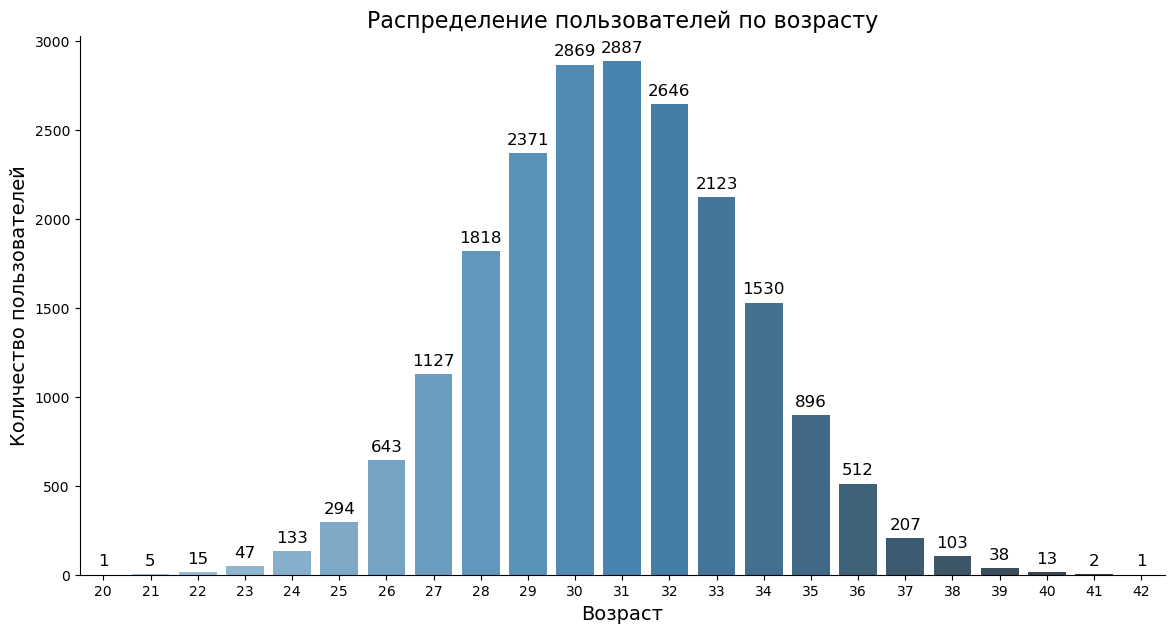

In [55]:
plt.figure(figsize=(14,7))

sns.barplot(data=Distribution_age_df, x='age', y='count_users', palette='Blues_d')

plt.title('Распределение пользователей по возрасту', fontsize=16)
plt.xlabel('Возраст', fontsize=14)
plt.ylabel('Количество пользователей', fontsize=14)

for i in range(len(Distribution_age_df)):
    plt.text(x=i, y=Distribution_age_df['count_users'][i] + 50, s=Distribution_age_df['count_users'][i], ha='center', fontsize=12)

sns.despine();


Мы можем наблюдать что основная масса наших клиентов находится в диапазоне от 27 до 35 лет. Скорее всего ценовая политика соответствует доходам и потребностям этого сегмента рынка или не доступна для других сегментов. следует также анализировать, как можно расширить потенциальную клиентскую базу, привлекая другие возрастные группы, и какие изменения в продукции, услуге, маркетинге или ценообразовании могут быть необходимы для этого.

## Топ 10 популярных продуктов :

In [41]:
top_10_products_qury = '''
    WITH t1 AS (
      SELECT 
        deliver_time,
        order_id
      FROM 
        courier_actions
      WHERE action = 'deliver_order'
      AND action != 'accept_order'
    ),
    t2 AS (
      SELECT 
        DISTINCT order_id,
        product_id
      FROM 
        orders 
        LATERAL VIEW explode(product_ids) exploded AS product_id
    )
    SELECT 
      name,
      COUNT(*) AS times_purchased
    FROM 
      t1
    JOIN t2 
      ON t1.order_id = t2.order_id
    JOIN products 
      ON t2.product_id = products.product_id
    GROUP BY 
      products.name
    ORDER BY 
      times_purchased DESC
    LIMIT 10;
'''
)

top_10_products = spark.sql(top_10_products_qury).toPandas()
top_10_products


product  sale_count
0                    хлеб        3829
1                  курица        3829
2                   сахар        3812
3                  бананы        3796
4                макароны        3785
5                   батон        3770
6  чай черный в пакетиках        3768
7                  молоко        3684
8        кофе растворимый        3516
9      масло подсолнечное        3452

In [ ]:
px.pie(
    top_10_products,
    names = "product",
    values = "sale_count",
    color_discrete_sequence = px.colors.sequential.BuPu_r
).update_layout(
    title = "Топ-10 самых популярных продуктов",
    legend_title = "Продукты",
    title_font_size=24,
    font_family='Arial',
    font_size=14,
    width=1000,
    height=600,
    legend_font_size=16,  # Увеличенный размер легенды
    margin=dict(l=50, r=50, t=70, b=50),
    paper_bgcolor='#F9F9F9',  # прозрачный фон
    plot_bgcolor='#F9F9F9'
).update_traces(
    textposition = "inside",
    textinfo = "label+value"
)

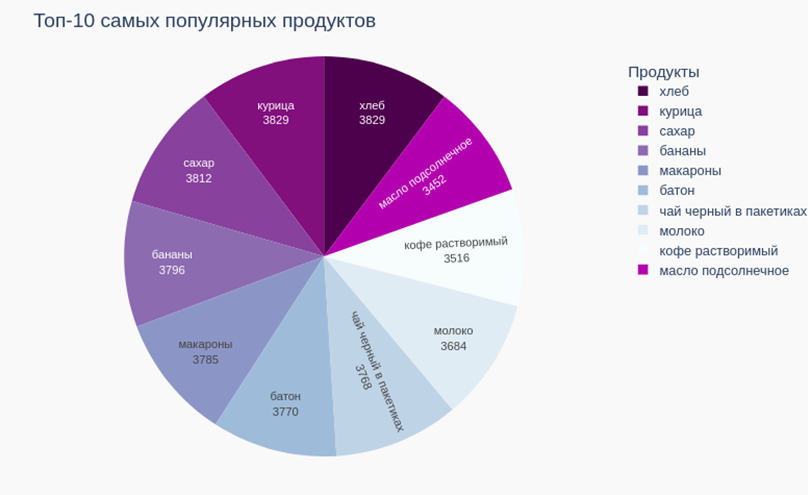

    Так как магазин только пришел на рынок, то следует идти на уступки покупателям, чтобы «переманить» их от конкурентов. 
    Для этого можно ввести скидки на популярные товары в дни наибольшей активности покупателей.


## Выручка по каждому из продуктов

In [43]:
revenue_products_query = '''
    WITH exploded_orders AS (
        SELECT
            order_id,
            exploded.product_id
        FROM
            orders
            LATERAL VIEW EXPLODE(product_ids) exploded AS product_id
        WHERE
            order_id NOT IN (
                SELECT
                    order_id
                 FROM
                     user_actions
                 WHERE
                     action = 'cancel_order'
             )
    )
    , products_revenue AS (
        SELECT
            products.name AS product_name,
            SUM(products.price) AS revenue,
            ROUND(100 * SUM(products.price) / SUM(SUM(products.price)) OVER(), 2) AS share_in_revenue
        FROM
            exploded_orders
            JOIN products 
            ON exploded_orders.product_id = products.product_id
        GROUP BY
            products.name
    )
    SELECT
        'OTHER' AS product_name,
        SUM(revenue) AS revenue,
        SUM(share_in_revenue) AS share_in_revenue
    FROM
        products_revenue
    WHERE
        share_in_revenue < 0.5
    GROUP BY
        'OTHER'
    UNION
    SELECT
        product_name,
        revenue,
        share_in_revenue
    FROM
        products_revenue
    WHERE
        share_in_revenue >= 0.5
    ORDER BY
        revenue DESC;
'''
revenue_products = spark.sql(revenue_products_query).toPandas()

revenue_products.head()

product_name    revenue  share_in_revenue
0          свинина  1437750.0              6.30
1            OTHER  1288045.0              5.64
2           курица  1234912.0              5.41
3  масло оливковое  1223550.0              5.36
4         говядина  1031930.0              4.52

In [ ]:
fig = px.pie(
    revenue_products.head(10), 
    values='revenue',
    names='product_name',
    hole=0.6,
    color_discrete_sequence=px.colors.sequential.Blugrn_r
)


# Настройка внешнего вида диаграммы
fig.update_layout(
    title='Доля продуктов в общей выручке',
    title_font_size=24,
    font_family='Arial',
    font_size=14,
    width=1000,
    height=600,
    legend_title='Продукты',
    legend_font_size=16,  # Увеличенный размер легенды
    margin=dict(l=50, r=50, t=70, b=50),
    paper_bgcolor='#F9F9F9',  # прозрачный фон
    plot_bgcolor='#F9F9F9',  # прозрачный фон
).update_traces(textposition = "inside", textinfo = "percent+label")

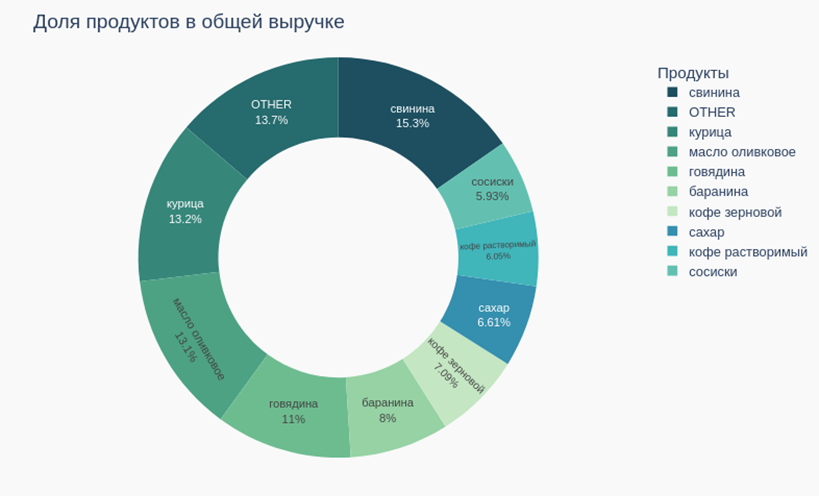

    Продукты, которые составляют менее 0,5% выручки сервиса, были объединены в отдельную категорию под названием «OTHER». На графике представлены топ-10 продуктов с самой высокой долей выручки. Среди этих продуктов можно увидеть свинину, курицу, говядину, сахар, кофе, баранину, сосиски и масло.
    
    Большая часть выручки сервиса приходится на топ-10 продуктов, что указывает на их популярность среди покупателей. Мясные продукты, такие как свинина, курица, говядина и баранина, являются основными источниками выручки, что может свидетельствовать о высоком спросе на мясные продукты среди клиентов сервиса.
    
    Исходя из вышеперечисленных наблюдений стоит провести дополнительный анализ данных, чтобы выявить возможности для увеличения продаж продуктов из категории «OTHER» или определить, стоит ли сосредоточиться на продвижении топ-10 продуктов для увеличения общей выручки.
